In [1]:
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister, Aer, execute
from qiskit.circuit.library.basis_change.qft import QFT
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt

## The main function

In [2]:
def binary_mlp(layer_nodes, input_x, input_y, x_precision=1, gatify=-1):
    """Sets up the circuit implementing a binary-weight MLP classifier

    Args:
        layer_nodes (list[int]): Number of neurons in layers 0-(N-1).
        input_x (np.ndarray(shape=(num_samples, layer_nodes[0]), dtype=int)): Values 0 to 2^(x_precision) - 1.
        input_y (np.ndarray(shape=(num_samples,), dtype=int)): Values 0 or 1
        x_precision (int): Precision of input x.
        gatify (int): Abstraction level for component functions.
        
    Returns:
        QuantumCircuit: A circuit implementing the MLP maximizing sum_{sample}[output * (y - 0.5)]
    """
    
    assert(input_x.shape[0] == input_y.shape[0] and input_x.shape[1] == layer_nodes[0])
    assert(x_precision > 0)
    
    log2_num_samples = np.log2(input_x.shape[0])
    if log2_num_samples != np.floor(log2_num_samples):
        raise RuntimeError('Can only handle input array with sizes in powers of 2')
        
    input_index_size = log2_num_samples.astype(int)
    
    num_layers = len(layer_nodes)
    full_layer_nodes = list(layer_nodes)
    full_layer_nodes.append(1)

    reg_input_index = QuantumRegister(input_index_size, 'index')
    reg_data_input_x = list(QuantumRegister(x_precision, 'x^{{{}}}'.format(i)) for i in range(layer_nodes[0]))
    reg_data_input_y = QuantumRegister(1, 'y')

    reg_data = [reg_data_input_x]
    reg_weights = []
    data_max = 2 ** x_precision
    for ilayer in range(num_layers):
        # could also think about truncating the layer inputs if compounding data size becomes an issue
        data_max *= layer_nodes[ilayer]
        data_width = np.ceil(np.log2(data_max)) + 1 # 1 for sign
        reg_data.append(list(QuantumRegister(data_width, 'd^{{l{}n{}}}'.format(ilayer + 1, n)) for n in range(full_layer_nodes[ilayer + 1])))
        weights = []
        for inode_next in range(full_layer_nodes[ilayer + 1]):
            weights.append(list(QuantumRegister(1, 'w^{{l{}n{}ton{}}}'.format(ilayer, n, inode_next)) for n in range(full_layer_nodes[ilayer])))
        reg_weights.append(weights)

    reg_amp = QuantumRegister(1, 'amp')

    circuit = QuantumCircuit()

    circuit += initialize_weights(reg_weights, gatify=gatify)

    circuit += load_data(reg_input_index, reg_data_input_x, reg_data_input_y[0], input_x, input_y, x_precision, gatify=gatify)
    if gatify >= 0:
        circuit.barrier()
            
    for ilayer in range(num_layers):
        layer_input = reg_data[ilayer]
        layer_output = reg_data[ilayer + 1]
        layer_weights = reg_weights[ilayer]
        
        circuit += propagate(layer_input, layer_weights, layer_output, ilayer > 0, gatify=gatify)
        if gatify >= 0:
            circuit.barrier()

    out_node_data = reg_data[num_layers][0]
    amp = reg_amp[0]
    circuit += transduce_amplitude(reg_data_input_y[0], out_node_data, amp, gatify=gatify)
    if gatify >= 0:
        circuit.barrier()
        
    circuit += aggregate_amplitudes(reg_input_index, gatify=gatify)
    
    return circuit

## Component functions

In [3]:
def to_gate(c, label):
    """Make a circuit where the argument is made into a composite gate.
    
    Args:
        c (QuantumCircuit): Circuit to turn into a gate.
        label (str): Gate name.

    Returns:
        QuantumCircuit: The circuit with the same set of registers as the input and a single gate
            corresponding to the input.
    """
    
    circuit = QuantumCircuit(*c.qregs)
    qubits = sum((reg[:] for reg in c.qregs), [])
    circuit.append(c.to_gate(label=label), qubits)
    return circuit

In [4]:
def initialize_weights(reg_weights, gatify=-1):
    """Initialize the weight registers into a full superposition state.
    
    Args:
        reg_weights (list[list[list[QuantumRegister]]]): weight registers
        
    Returns:
        QuantumCircuit: Circuit corresponding to this subroutine.
    """
    
    registers = []
    for reglists in reg_weights:
        for regs in reglists:
            registers += regs

    circuit = QuantumCircuit(*registers)
    
    # Make weights a full superposition
    for reg in registers:
        circuit.h(reg)

    if gatify != 0:
        return to_gate(circuit, 'initialize_weights')
    else:
        return circuit

In [5]:
def to_binary(arr, width):
    """Convert an array of integers with shape S into an array of uint8 with shape (S + [n])
    where n is the number of uint8s needed to accommodate `width`-wide integers
    
    Args:
        arr (np.ndarray): Input array.
        width (int): Width of the input (specification of input maximum as 2**width).
        
    Returns:
        np.ndarray: Binarized array.
    """

    ndiv = (width // 8) + 1
    if width % 8 == 0:
        ndiv -= 1
        
    uint8_arr = np.empty(arr.shape + (ndiv,), dtype=np.uint8)
    for idiv in range(ndiv):
        uint8_arr[..., idiv] = (arr >> (8 * idiv)) & 0xff
        
    binary_arr = np.unpackbits(uint8_arr, axis=-1, bitorder='little')[..., :width]
    
    return binary_arr

def load_sample_x(reg_data_input_x, binary_x, gatify=-1):
    """Load the input x data of a sample into the register.
    
    Args:
        reg_data_input_x (QuantumRegister): Register to store the x values.
        x (np.ndarray): Value of x for a sample in binary (shape [ndim, precision])
        
    Returns:
        QuantumCircuit: Circuit corresponding to this subroutine.
    """
    
    reg_ancilla = AncillaRegister(1, 'ancilla')
    ancilla = reg_ancilla[0]

    registers = reg_data_input_x + [reg_ancilla]
    circuit = QuantumCircuit(*registers)

    for idim in range(binary_x.shape[0]):
        reg = reg_data_input_x[idim]
        for bit in binary_x[idim].nonzero()[0]:
            circuit.cx(ancilla, reg[bit])
            
    if gatify < 0 or gatify >= 1:
        return to_gate(circuit, 'load_sample_x')
    else:
        return circuit

def load_sample(reg_input_index, reg_data_input_x, data_input_y, binary_index, binary_x, y, gatify=-1):
    """Load the x and y data of a sample into the registers.
    
    Args:
        reg_input_index (QuantumRegister): Index register.
        reg_data_input_x (QuantumRegister): Register to store the x values.
        data_input_y (Qubit): Qubit to store the y values.
        binary_index (np.ndarray): Binarized index of the sample.
        binary_x (np.ndarray): Binarized x value of the sample.
        y (int): Y value.
        
    Returns:
        QuantumCircuit: Circuit corresponding to this subroutine.
    """
    
    reg_ancilla = AncillaRegister(1, 'ancilla')
    ancilla = reg_ancilla[0]

    registers = [reg_input_index] + reg_data_input_x + [data_input_y.register, reg_ancilla]
    circuit = QuantumCircuit(*registers)
    
    for bit in (1 - binary_index).nonzero()[0]:
        circuit.x(reg_input_index[bit])

    circuit.mcx(reg_input_index, ancilla)

    circuit += load_sample_x(reg_data_input_x, binary_x, gatify=gatify)

    if y == 1:
        circuit.cx(ancilla, data_input_y)

    circuit.mcx(reg_input_index, ancilla)

    for bit in (1 - binary_index).nonzero()[0]:
        circuit.x(reg_input_index[bit])
        
    if gatify < 0 or gatify >= 2:
        return to_gate(circuit, 'load_sample')
    else:
        return circuit
    
def load_data(reg_input_index, reg_data_input_x, data_input_y, input_x, input_y, x_precision=1, gatify=-1):
    """Load the x and y data into registers.
    
    Args:
        reg_input_index (QuantumRegister): register indexing the input samples.
        reg_data_input_x (list[QuantumRegister]): register storing the input x values.
        data_input_y (Qubit): Qubit storing the input y values.
        input_x (np.ndarray): input x values.
        input_y (np.ndarray): input y values.
        x_precision (int): precision of input x.
        
    Returns:
        QuantumCircuit: circuit corresponding to this subroutine.
    """
    
    registers = [reg_input_index] + reg_data_input_x + [data_input_y.register]
    circuit = QuantumCircuit(*registers)

    circuit.h(reg_input_index)
    
    index_width = np.log2(input_x.shape[0]).astype(int)
    indices = np.arange(input_x.shape[0], dtype=int)
    
    binary_indices = to_binary(indices, index_width)

    binary_x = to_binary(input_x, x_precision)

    for idx in range(input_x.shape[0]):
        binary_index = binary_indices[idx]
        x = binary_x[idx]
        y = input_y[idx]
        
        circuit += load_sample(reg_input_index, reg_data_input_x, data_input_y, binary_index, x, y, gatify=gatify)
            
    if gatify < 0 or gatify >= 3:
        return to_gate(circuit, 'load_data')
    else:
        return circuit

In [6]:
def accumulate_phase_single(data, idigit, weight, targ, activation, gatify=-1):
    """Multiply one bit from the output of a node in the previous layer with the weight and
    pass the result to the target node.
    
    Args:
        data (QuantumRegister): Input data for one node in the previous layer.
        idigit (int): Digit number of the input.
        weight (Qubit): Binary weight connecting the input and target nodes.
        targ (QuantumRegister): Input data for the target node.
        activation (bool): If True, last bit of data is considered as the sign bit
            and data is propagated only if this bit is 0.
            
    Returns:
        QuantumCircuit: Circuit corresponding to this subroutine.
    """
    reg_ancilla = AncillaRegister(1, 'ancilla')
    ancilla = reg_ancilla[0]
    reg_ancilla_activation = AncillaRegister(1, 'activation')
    ancilla_activation = reg_ancilla_activation[0]
    circuit = QuantumCircuit(data, weight.register, targ, reg_ancilla, reg_ancilla_activation)
    
    data_bit = data[idigit]
    
    if activation:
        sign_bit = data[-1]
        # because of x(data[-1]) in the parent function, sign_bit is 1 if sign of data is positive
        circuit.mcx([data_bit, sign_bit], ancilla_activation)
        data_ctrl = ancilla_activation
    else:
        data_ctrl = data_bit

    dphi = 2. * np.pi / (2 ** targ.size)
        
    for itarg in range(targ.size):
        circuit.mcx([data_ctrl, targ[itarg]], ancilla)
        circuit.crz(2. * dphi * (2 ** (idigit + itarg)), ancilla, weight) # phase + w*(x[d]&t)*dphi*2^(d+t) [note rz(2*theta) = exp(-theta Z)]
        circuit.mcx([data_ctrl, targ[itarg]], ancilla)

    if activation:
        circuit.mcx([data_bit, sign_bit], ancilla_activation)
        
    if gatify < 0 or gatify >= 1:
        return to_gate(circuit, 'accumulate_phase_single')
    else:
        return circuit

def accumulate_phase(data, weight, targ, activation, gatify=-1):
    """Multiply the output of a node in the previous layer with the weight and
    pass the result to the target node.
    
    Args:
        data (QuantumRegister): Input data for one node in the previous layer.
        weight (Qubit): Binary weight connecting the input and target nodes.
        targ (QuantumRegister): Input data for the target node.
        activation (bool): If True, last bit of data is considered as the sign bit
            and data is propagated only if this bit is 0.
            
    Returns:
        QuantumCircuit: Circuit corresponding to this subroutine.
    """

    circuit = QuantumCircuit(data, weight.register, targ)
    
    if activation:
        max_digits = data.size - 1        
        circuit.x(data[-1]) # relu activation -> only apply rz when the sign bit is 0
    else:
        max_digits = data.size
        
    for idigit in range(max_digits):
        circuit += accumulate_phase_single(data, idigit, weight, targ, activation, gatify=gatify)
        
    if activation:
        circuit.x(data[-1]) # relu activation -> only apply rz when the sign bit is 0
        
    if gatify < 0 or gatify >= 2:
        return to_gate(circuit, 'accumulate_phase')
    else:
        return circuit
    
def inverse_qft(targ, gatify=-1):
    circuit = QuantumCircuit(targ)
    
    iqft = QFT(targ.size, inverse=True, do_swaps=False)
    circuit.compose(iqft, targ, inplace=True)
    for iq in range(targ.size // 2):
        circuit.swap(targ[iq], targ[-iq - 1])
        
    if gatify < 0 or gatify >= 1:
        return to_gate(circuit, 'inverse_qft')
    else:
        return circuit

def propagate_one(layer_input, weights, targ, activation, gatify=-1):
    """Propagate the output of all nodes in the previous layer through weights
    to the target node.
    
    Args:
        layer_input (list[QuantumRegister]): Input data for nodes in the previous layer.
        weights (list[QuantumRegister]): Binary weights connecting the input nodes to the target.
        targ (QuantumRegister): Input data for the target node.
        activation (bool): Whether to activate layer_input with ReLU.
        
    Returns:
        QuantumCircuit: Circuit corresponding to this subroutine.
    """

    registers = layer_input + weights + [targ]
    circuit = QuantumCircuit(*registers)
    
    # Prepare the next input register for phase estimation
    circuit.h(targ)

    for data, weight in zip(layer_input, weights):
        # weight qubit: 0 -> w=-1, 1 -> w=+1
        circuit += accumulate_phase(data, weight[0], targ, activation, gatify=gatify)

    circuit += inverse_qft(targ)

    if gatify < 0 or gatify >= 3:
        return to_gate(circuit, 'propagate_one')
    else:
        return circuit
    
def propagate(layer_input, layer_weights, layer_output, activation, gatify=-1):
    """Propagate the output of all nodes in the previous layer through weights.
    
    Args:
        layer_input (list[QuantumRegister]): Input data for nodes in the previous layer.
        layer_weights (list[list[QuantumRegister]]): Binary weights connecting the input nodes to the target.
        layer_output (list[QuantumRegister]): Input data for the target nodes.
        activation (bool): Whether to activate layer_input with ReLU.
        
    Returns:
        QuantumCircuit: Circuit corresponding to this subroutine.
    """
    
    registers = layer_input + sum(layer_weights, []) + layer_output
    circuit = QuantumCircuit(*registers)
    
    for weights, targ in zip(layer_weights, layer_output):
        circuit += propagate_one(layer_input, weights, targ, activation, gatify=gatify)

    if gatify < 0 or gatify >= 4:
        return to_gate(circuit, 'propagate')
    else:
        return circuit

In [7]:
def transduce_amplitude(y, out_node_data, amp, gatify=-1):
    """Transduce the amplitude [cos(pi/2 - out)] for each sample from the output node data.
    Normalizes out so that we work in the upper quadrant.
    
    Args:
        y (Qubit): Input y.
        out_node_data (QuantumRegister): Register containing data for the output node.
        amp (Qubit): Qubit to perform Ry rotations on.
        
    Returns:
        QuantumCircuit: Circuit corresponding to this subroutine.
    """

    circuit = QuantumCircuit(y.register, out_node_data, amp.register)

    # Will use H-Rz-H instead of repeated Rys
    circuit.h(amp)
    circuit.rz(-np.pi, amp)

    # Flip the ancilla according to the parity between the sign of the output node data and input y
    # (o<0 && y==1) or (o>=0 && y==0) -> reduce amplitude
    sign_bit = out_node_data[-1]
    circuit.cx(y, sign_bit)

    # sign_bit==1 implies parity==-1. Flip the phase of the amp qubit using the identity
    # X-Rz(phi)-X = Rz(-phi)
    circuit.cx(sign_bit, amp)
    
    dtheta = np.pi / 2. / (2 ** (out_node_data.size - 1))
    for idigit in range(out_node_data.size - 1):
        # We want to increase the amplitude when the parity is -1
        # -> reduce the phase when the parity is -1
        # -> reduce the phase when the phase is flipped through the cx above
        # -> increase the phase
        # -> perform Rz(-theta) = exp(+i theta/2 Z)
        circuit.crz(-2. * dtheta * (2 ** idigit), out_node_data[idigit], amp)
        
    circuit.cx(sign_bit, amp)
    circuit.cx(y, sign_bit)

    circuit.h(amp)

    if gatify != 0:
        return to_gate(circuit, 'transduce_amplitude')
    else:
        return circuit

In [8]:
def aggregate_amplitudes(reg_input_index, gatify=-1):
    """Set the amplitude of |0> to [sum_{sample} cos(pi/2 - out_{sample})].
    
    Args:
        reg_input_index: Index register.
        
    Returns:
        QuantumCircuit: Circuit corresponding to this subroutine.
    """
    
    circuit = QuantumCircuit(reg_input_index)
        
    # Basis change - amplitude of |0> will be [sum_{sample} sin(pi/4 + out_sample)]
    circuit.h(reg_input_index)

    if gatify != 0:
        return to_gate(circuit, 'aggregate_amplitudes')
    else:
        return circuit

## Unit tests

In [9]:
from qiskit.quantum_info import Statevector, Operator
statevector_simulator = Aer.get_backend('statevector_simulator')
statevector_simulator.set_options(method='statevector_gpu')

In [10]:
def get_vector_and_probs(circuit):
    data = execute(circuit, statevector_simulator).result().data()['statevector']
    data = data.reshape(tuple(2 ** reg.size for reg in reversed(circuit.qregs)))
    data.real = np.where(np.abs(data.real) > 1.e-8, data.real, 0.)
    data.imag = np.where(np.abs(data.imag) > 1.e-8, data.imag, 0.)
    probs = np.square(np.abs(data))
    
    return data, probs

### Data loading

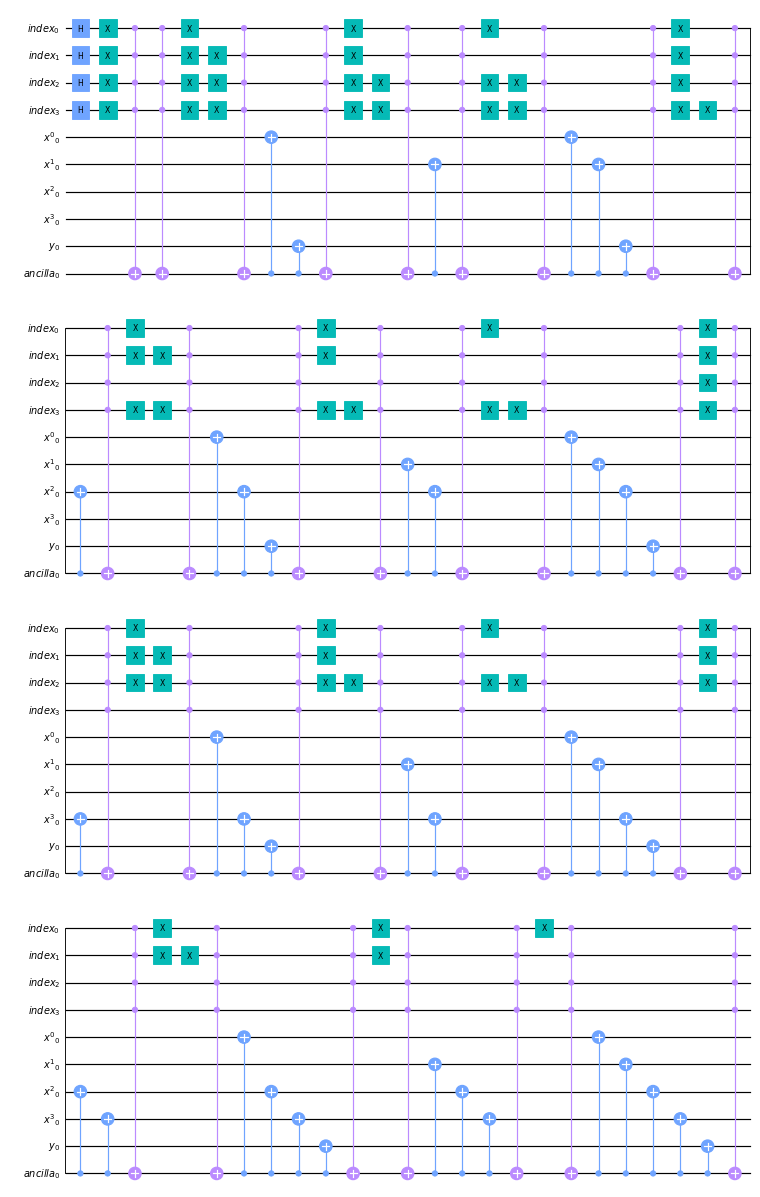

In [11]:
log2_num_samples = 4
x_dim = 4
x_precision = 1
reg_index = QuantumRegister(log2_num_samples, 'index')
reg_x = list(QuantumRegister(x_precision, 'x^{{{}}}'.format(i)) for i in range(x_dim))
reg_y = QuantumRegister(1, 'y')
# using to_binary because x_precision is 1
x = to_binary(np.arange(2 ** log2_num_samples), log2_num_samples)
y = np.tile(np.array([0, 1]), 2 ** (log2_num_samples - 1))

data_loading_circuit = load_data(reg_index, reg_x, reg_y[0], x, y, gatify=0)
data_loading_circuit.draw('mpl', scale=0.6)

In [12]:
data, probs = get_vector_and_probs(data_loading_circuit)

data = np.zeros(2 ** circuit.num_qubits, dtype=np.complex128)
data[0] = 1.+0.j
state = Statevector(data)
operator = Operator(circuit)
state = state.evolve(operator)
data = state.data.reshape((2, 2, 2 ** sum(reg.size for reg in reg_x), 2 ** reg_index.size))
data = np.where(np.abs(data) > 1.e-8, data, 0.)
probs = np.square(np.abs(data))

In [13]:
ndim = len(data_loading_circuit.qregs)
print('Ancilla is clean:', np.sum(probs, axis=tuple(range(1, ndim))))
print('Probability per index:', np.sum(probs, axis=tuple(range(ndim - 1))))
print('Nonzero indices:', np.stack(data[0].nonzero()).T)

Ancilla is clean: [1. 0.]
Probability per index: [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
Nonzero indices: [[ 0  0  0  0  0  0]
 [ 0  0  0  1  0  2]
 [ 0  0  1  0  0  4]
 [ 0  0  1  1  0  6]
 [ 0  1  0  0  0  8]
 [ 0  1  0  1  0 10]
 [ 0  1  1  0  0 12]
 [ 0  1  1  1  0 14]
 [ 1  0  0  0  1  1]
 [ 1  0  0  1  1  3]
 [ 1  0  1  0  1  5]
 [ 1  0  1  1  1  7]
 [ 1  1  0  0  1  9]
 [ 1  1  0  1  1 11]
 [ 1  1  1  0  1 13]
 [ 1  1  1  1  1 15]]


### Data propagation

#### Single bit

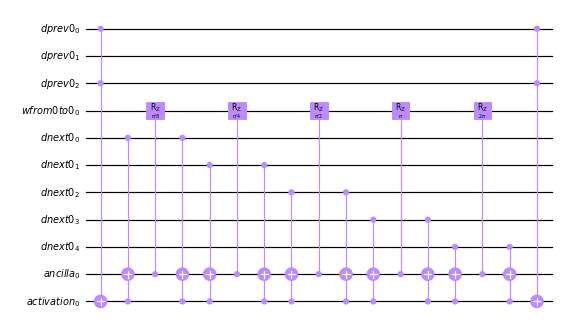

In [14]:
prev_layer_num_nodes = 3
prev_layer_d_width = 2
next_layer_num_nodes = 2
next_layer_d_width = prev_layer_d_width + np.ceil(np.log2(prev_layer_num_nodes))

layer_input = list(QuantumRegister(prev_layer_d_width + 1, 'dprev{}'.format(i)) for i in range(prev_layer_num_nodes))
layer_weights = list(list(QuantumRegister(1, 'wfrom{}to{}'.format(iprev, inext)) for iprev in range(prev_layer_num_nodes)) for inext in range(next_layer_num_nodes))
layer_output = list(QuantumRegister(next_layer_d_width + 1, 'dnext{}'.format(i)) for i in range(next_layer_num_nodes))

single_accum_circuit = accumulate_phase_single(layer_input[0], 0, layer_weights[0][0][0], layer_output[0], True, gatify=0)
single_accum_circuit.draw('mpl', scale=0.6)

In [15]:
test_circuit = QuantumCircuit(*single_accum_circuit.qregs)
# x = -1, w = 1 -> o = sum_{k} |k> (relu activation: no propagation)
test_circuit.x(layer_input[0])
test_circuit.x(layer_weights[0][0])
test_circuit.h(layer_output[0])
# accummulate_phase applies an X to the sign bit
test_circuit.x(layer_input[0][-1])
test_circuit += single_accum_circuit
test_circuit.x(layer_input[0][-1])

data, probs = get_vector_and_probs(test_circuit)

In [16]:
ndim = len(single_accum_circuit.qregs)
print('Ancilla is clean:', np.sum(probs, axis=tuple(range(2, ndim))))
probs_noanc = probs[0, 0]
data_noanc = data[0, 0]
ndim -= 1
print('No change to input:', np.sum(probs_noanc, axis=0))
data_output = data_noanc[data_noanc.nonzero()]
print('Output phase:', np.log(data_output).imag / np.pi)

Ancilla is clean: [[1. 0.]
 [0. 0.]]
No change to input: [[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
Output phase: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
test_circuit = QuantumCircuit(*single_accum_circuit.qregs)
# x = 1, w = 0 -> o = sum_{k} exp(2*pi*i/8 * (-1) * k) |k>
test_circuit.x(layer_input[0][0])
#test_circuit.x(layer_weights[0][0])
test_circuit.h(layer_output[0])
# accummulate_phase applies an X to the sign bit
test_circuit.x(layer_input[0][-1])
test_circuit += single_accum_circuit
test_circuit.x(layer_input[0][-1])

data, probs = get_vector_and_probs(test_circuit)

In [18]:
ndim = len(single_accum_circuit.qregs)
print('Ancilla is clean:', np.sum(probs, axis=tuple(range(2, ndim))))
probs_noanc = probs[0, 0]
data_noanc = data[0, 0]
print('No change to input:', np.sum(probs_noanc, axis=0))
data_output = data_noanc[data_noanc.nonzero()]
print('Output phase:', np.log(data_output).imag / np.pi)

Ancilla is clean: [[1. 0.]
 [0. 0.]]
No change to input: [[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Output phase: [ 0.     -0.0625 -0.125  -0.1875 -0.25   -0.3125 -0.375  -0.4375 -0.5
 -0.5625 -0.625  -0.6875 -0.75   -0.8125 -0.875  -0.9375  1.      0.9375
  0.875   0.8125  0.75    0.6875  0.625   0.5625  0.5     0.4375  0.375
  0.3125  0.25    0.1875  0.125   0.0625]


#### Single output node

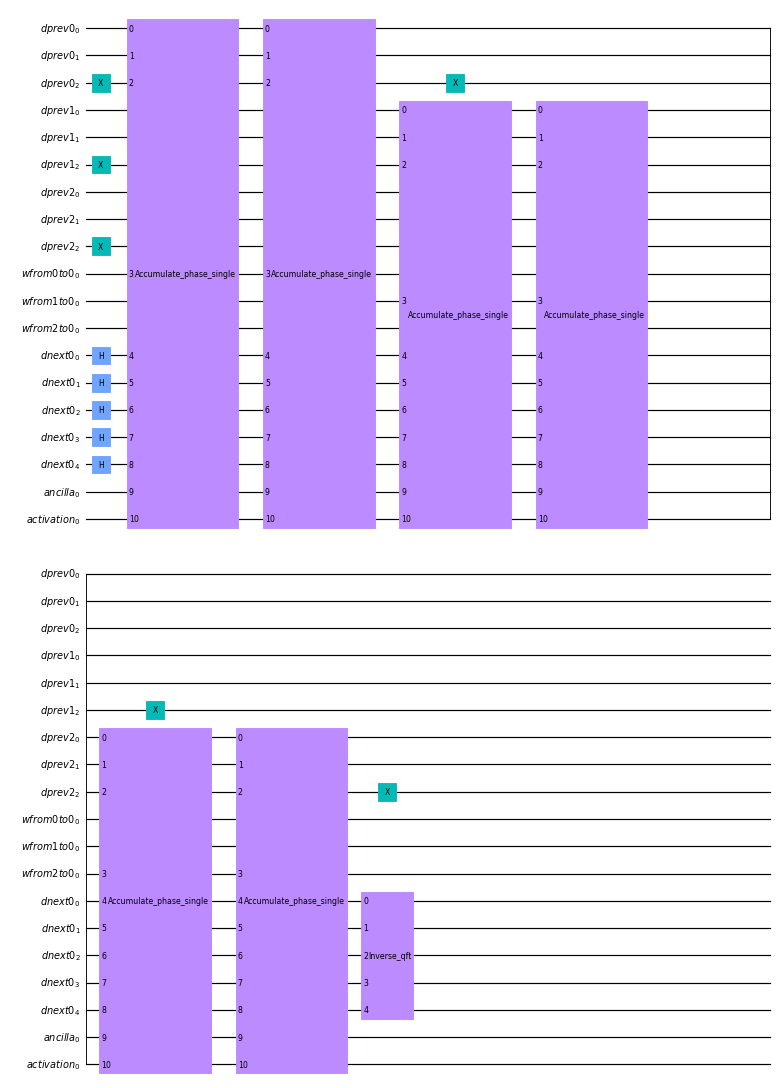

In [19]:
single_propagation_circuit = propagate_one(layer_input, layer_weights[0], layer_output[0], True, gatify=1)
single_propagation_circuit.draw('mpl', scale=0.6)

In [20]:
test_circuit = QuantumCircuit(*single_propagation_circuit.qregs)
# x_0 = -1, x_1 = 2, x_2 = 3; w_0 = -1, w_1 = 1, w_2 = -1 -> o = |-1>
test_circuit.x(layer_input[0])
test_circuit.x(layer_input[1][1])
test_circuit.x(layer_input[2][0])
test_circuit.x(layer_input[2][1])
test_circuit.x(layer_weights[0][1])
test_circuit += single_propagation_circuit

data, probs = get_vector_and_probs(test_circuit)

In [21]:
ndim = len(single_propagation_circuit.qregs)
print('Ancilla is clean:', np.sum(probs, axis=tuple(range(2, ndim))))
probs_noanc = probs[0, 0]
data_noanc = data[0, 0]
nonzero_elem = np.flip(np.squeeze(np.stack(np.sum(probs_noanc, axis=0).nonzero())))
print('No change to input:', nonzero_elem)
print('Output:', data_noanc.nonzero()[0])

Ancilla is clean: [[1. 0.]
 [0. 0.]]
No change to input: [7 2 3 0 1 0]
Output: [31]


#### Layer output

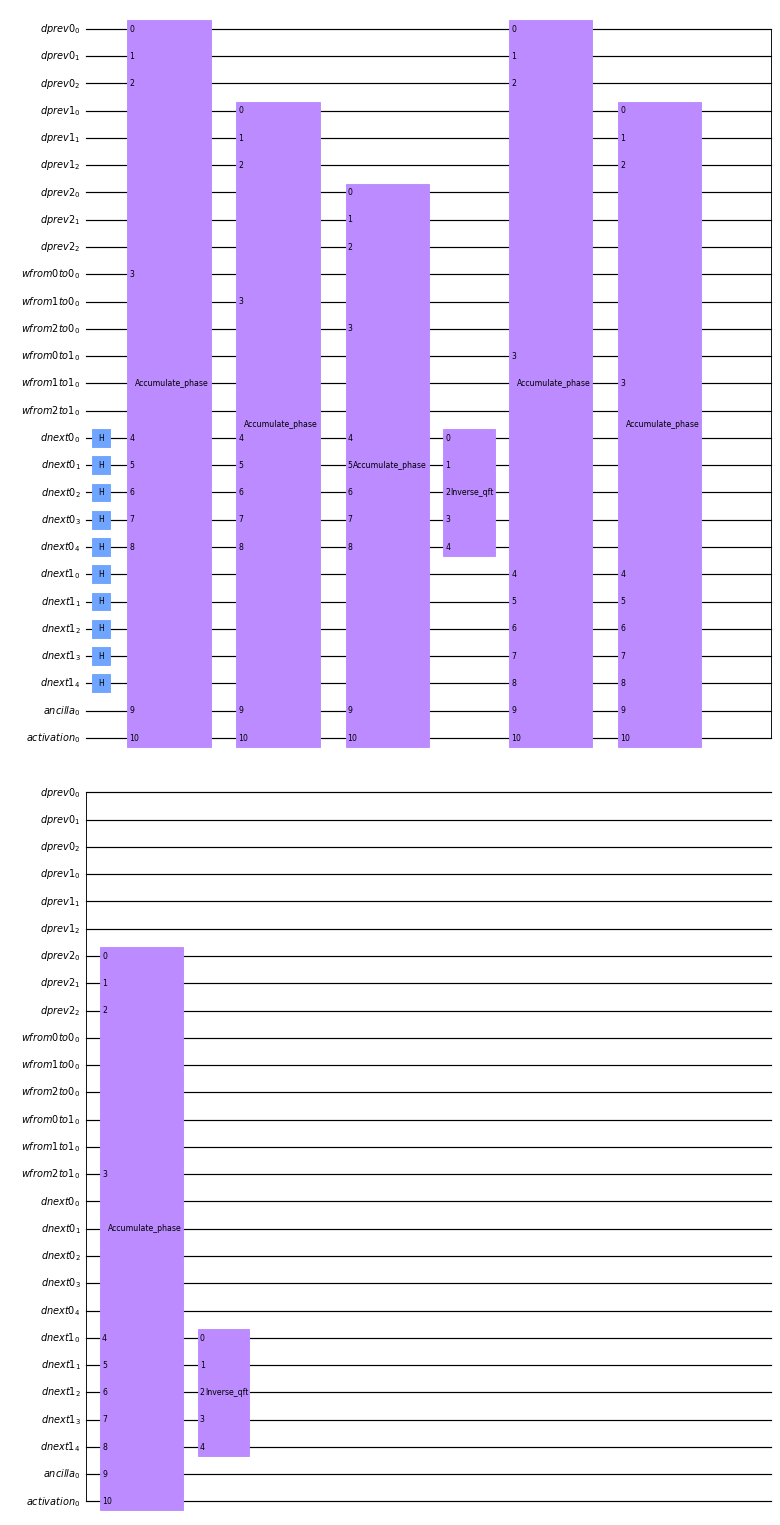

In [22]:
propagation_circuit = propagate(layer_input, layer_weights, layer_output, True, gatify=2)
propagation_circuit.draw('mpl', scale=0.6)

In [23]:
test_circuit = QuantumCircuit(*propagation_circuit.qregs)
# x_0 = -1, x_1 = 2, x_2 = 3
# w^0_0 = -1, w^0_1 = 1, w^0_2 = -1
# w^1_0 = -1, w^1_1 = 1, w^1_2 = 1
#-> o = |-1>|5>
test_circuit.x(layer_input[0])
test_circuit.x(layer_input[1][1])
test_circuit.x(layer_input[2][0])
test_circuit.x(layer_input[2][1])
test_circuit.x(layer_weights[0][1])
test_circuit.x(layer_weights[1][1])
test_circuit.x(layer_weights[1][2])
test_circuit += propagation_circuit

data, probs = get_vector_and_probs(test_circuit)

In [24]:
ndim = len(propagation_circuit.qregs)
print('Ancilla is clean:', np.sum(probs, axis=tuple(range(2, ndim))))
probs_noanc = probs[0, 0]
data_noanc = data[0, 0]
nonzero_elem = np.flip(np.squeeze(np.stack(np.sum(probs_noanc, axis=(0, 1)).nonzero())))
print('No change to input:', nonzero_elem)
nonzero_elems = data_noanc.nonzero()
print('Output:', nonzero_elems[1], nonzero_elems[0])

Ancilla is clean: [[1. 0.]
 [0. 0.]]
No change to input: [7 2 3 0 1 0 0 1 1]
Output: [31] [5]


### Amplitude transduction

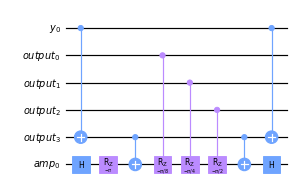

In [25]:
reg_y = QuantumRegister(1, 'y')
out_node_data = QuantumRegister(4, 'output')
reg_amp = QuantumRegister(1, 'amp')

transduction_circuit = transduce_amplitude(reg_y[0], out_node_data, reg_amp[0], gatify=0)
transduction_circuit.draw('mpl', scale=0.6)

In [26]:
test_circuit = QuantumCircuit(*transduction_circuit.qregs)
# y = 1, output = 6 -> amp = cos(pi/2 * (1 - 6/8))
test_circuit.x(reg_y[0])
test_circuit.x(out_node_data[1])
test_circuit.x(out_node_data[2])
test_circuit += transduction_circuit

data, probs = get_vector_and_probs(test_circuit)

In [27]:
amp_probs = np.sum(probs, axis=(1, 2))
print('Probs:', amp_probs)
theta = np.arccos(np.sqrt(amp_probs[0])) / np.pi * 2.
print('Theta:', theta, '* pi/2')

Probs: [0.85355339 0.14644661]
Theta: 0.25000000000000006 * pi/2


In [28]:
test_circuit = QuantumCircuit(*transduction_circuit.qregs)
# y = -1, output = -3 -> amp = cos(pi/2 * (1 - 3/8))
test_circuit.x(out_node_data[0])
test_circuit.x(out_node_data[1])
test_circuit.x(out_node_data[3])
test_circuit += transduction_circuit

data, probs = get_vector_and_probs(test_circuit)

In [29]:
amp_probs = np.sum(probs, axis=(1, 2))
print('Probs:', amp_probs)
theta = np.arccos(np.sqrt(amp_probs[0])) / np.pi * 2.
print('Theta:', theta, '* pi/2')

Probs: [0.30865828 0.69134172]
Theta: 0.6250000000000001 * pi/2


## Example full circuit

24 qubits


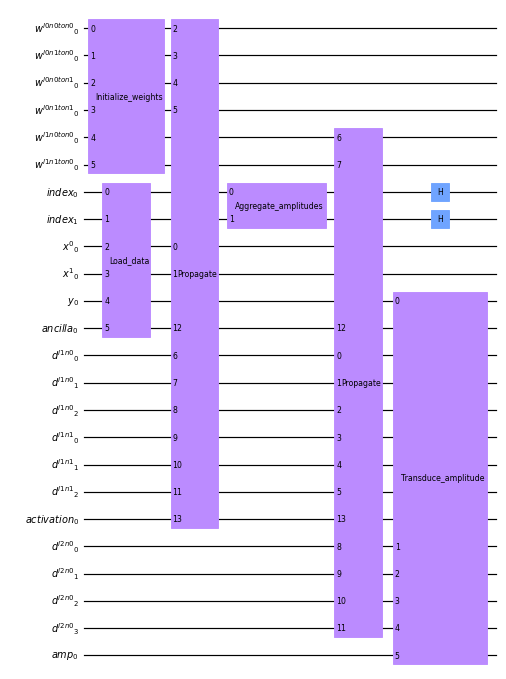

In [30]:
layer_nodes = [2, 2]
input_x = to_binary(np.arange(4), 2)
input_y = np.array([1, 0, 0, 1])
circuit = binary_mlp(layer_nodes, input_x, input_y)
# debugging
index_reg = next(reg for reg in circuit.qregs if reg.name == 'index')
circuit.h(index_reg)

print(circuit.num_qubits, 'qubits')
circuit.draw('mpl', scale=0.6)

In [31]:
data, probs = get_vector_and_probs(circuit)

In [42]:
qregs = list(reversed(circuit.qregs))
num_regs = len(circuit.qregs)

ancilla_idx = next(i for i, reg in enumerate(qregs) if reg.name == 'ancilla')
activation_idx = next(i for i, reg in enumerate(qregs) if reg.name == 'activation')
index_idx = next(i for i, reg in enumerate(qregs) if reg.name == 'index')

print(data.shape, index_idx)

axis = list(range(num_regs))
axis.remove(ancilla_idx)
axis.remove(activation_idx)
print('Ancilla is clean:', np.sum(probs, axis=tuple(axis)))
#nonzero_indices = np.stack(data.nonzero()).T
#nonzero_indices = nonzero_indices[:, np.array(axis)]
#print('Nonzero indices:', nonzero_indices)
#nonzero_indices_index0 = np.array([indices for indices in nonzero_indices if indices[7] == 0])
#print(nonzero_indices_index0.shape)
#nonzero_indices_index1 = np.array([indices for indices in nonzero_indices if indices[7] == 1])
#print(nonzero_indices_index1.shape)
#nonzero_indices_index2 = np.array([indices for indices in nonzero_indices if indices[7] == 2])
#print(nonzero_indices_index2.shape)
#nonzero_indices_index3 = np.array([indices for indices in nonzero_indices if indices[7] == 3])
#print(nonzero_indices_index3.shape)
#print('Nonzero indices for input 0:', nonzero_indices_index0)
#print('Nonzero indices for input 1:', nonzero_indices_index1)
#print('Nonzero indices for input 2:', nonzero_indices_index2)
#print('Nonzero indices for input 3:', nonzero_indices_index3)
d = data[:, :, 0, :, :, 0, 0, :, :, 2, 1, 1, 1, 1, 1, 1]
print(d.shape)
print(np.stack(d.nonzero()).T)
axis = list(range(num_regs))
axis.remove(index_idx)
print('Probability per index:', np.sum(probs, axis=tuple(axis)))

(2, 16, 2, 8, 8, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2) 9
Ancilla is clean: [[1. 0.]
 [0. 0.]]
(2, 16, 8, 8, 2, 2)
[[0 2 1 1 1 0]
 [1 2 1 1 1 0]]
Probability per index: [0.25 0.25 0.25 0.25]


In [49]:
num_weight_regs = 0
full_layer_nodes = list(layer_nodes) + [1]
for il in range(len(layer_nodes)):
    num_weight_regs += full_layer_nodes[il] * full_layer_nodes[il + 1]

num_regs = len(circuit.qregs)
sum_axes = list(range(num_regs))
sum_axes.remove(0) # amp
sum_axes.remove(num_regs - 1 - num_weight_regs) # index
for i in range(num_weight_regs):
    sum_axes.remove(num_regs - 1 - i)
    
reduced_probs = np.sum(probs, axis=tuple(sum_axes))
weight_probs = reduced_probs[0, 0]
print(weight_probs)

(2, 4, 2, 2, 2, 2, 2, 2)
[[[[[[0.00000000e+00 9.39394303e-04]
     [9.39394303e-04 2.71233684e-03]]

    [[9.39394303e-04 8.33548233e-04]
     [1.87878861e-03 2.60649077e-03]]]


   [[[9.39394303e-04 1.87878861e-03]
     [8.33548233e-04 2.60649077e-03]]

    [[2.71233684e-03 2.60649077e-03]
     [2.60649077e-03 2.15537772e-03]]]]



  [[[[0.00000000e+00 3.71681970e-05]
     [3.71681970e-05 2.17350661e-04]]

    [[9.39394303e-04 0.00000000e+00]
     [9.76562500e-04 1.80182464e-04]]]


   [[[9.39394303e-04 9.76562500e-04]
     [0.00000000e+00 1.80182464e-04]]

    [[2.71233684e-03 1.77294254e-03]
     [1.77294254e-03 0.00000000e+00]]]]]




 [[[[[0.00000000e+00 9.39394303e-04]
     [9.39394303e-04 2.71233684e-03]]

    [[3.71681970e-05 0.00000000e+00]
     [9.76562500e-04 1.77294254e-03]]]


   [[[3.71681970e-05 9.76562500e-04]
     [0.00000000e+00 1.77294254e-03]]

    [[2.17350661e-04 1.80182464e-04]
     [1.80182464e-04 0.00000000e+00]]]]



  [[[[0.00000000e+00 3.71681970e-05]
     [

## Validation

In [47]:
print(input_x)
weights_0 = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]]).T
print(input_x @ weights_0)

[[0 0]
 [1 0]
 [0 1]
 [1 1]]
[[ 0  0  0  0]
 [-1 -1  1  1]
 [-1  1 -1  1]
 [-2  0  0  2]]
